# Jonathan Halverson
# Keeping it Fresh: Predict Restaurant Inspections
## Part 4: Yelp user data

In this notebook we explore the Yelp user data and join it to the user reviews. Our interest is in normalizing each user's star rating by the average rating of all of their reviews.

We might be tempted to weight reviews by the number of votes they received. However, we do not know whether the votes were made during the inspection window or not so this will not be done.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

### Load the user data

In [2]:
from helper_methods import read_json
df_usr = read_json('data/yelp_academic_dataset_user.json')
df_usr.head(3)

,average_stars,compliments,elite,fans,friends,name,review_count,type,user_id,votes,yelping_since
0,4.25,"{u'profile': 2, u'cute': 10, u'funny': 4, u'pl...","[2005, 2006, 2007]",17,"[rpOyqD_893cqmDAtJLbdog, 4U9kSBLuBDU391x6bxU-Y...",Brandon,193,user,E24Bu-vMhVpueQpU8mpRPw,"{u'funny': 100, u'useful': 233, u'cool': 120}",2004-10
1,3.65,"{u'profile': 112, u'cute': 205, u'funny': 572,...","[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",1048,"[E24Bu-vMhVpueQpU8mpRPw, 4U9kSBLuBDU391x6bxU-Y...",Jeremy,1251,user,rpOyqD_893cqmDAtJLbdog,"{u'funny': 7143, u'useful': 13200, u'cool': 10...",2004-10
2,3.59,"{u'profile': 8, u'cute': 23, u'funny': 122, u'...","[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",93,"[E24Bu-vMhVpueQpU8mpRPw, rpOyqD_893cqmDAtJLbdo...",Michael,442,user,4U9kSBLuBDU391x6bxU-YA,"{u'funny': 915, u'useful': 1464, u'cool': 734}",2004-10


In [3]:
df_usr['yelping_since'] = pd.to_datetime(df_usr['yelping_since'])
df_usr['years_elite'] = df_usr['elite'].apply(len)
df_usr['number_of_friends'] = df_usr['friends'].apply(len)
df_usr['votes_funny'] = df_usr['votes'].apply(lambda x: x['funny'])
df_usr['votes_useful'] = df_usr['votes'].apply(lambda x: x['useful'])
df_usr['votes_cool'] = df_usr['votes'].apply(lambda x: x['cool'])
df_usr['compliments_total'] = df_usr['compliments'].apply(lambda x: sum(x.values()))
df_usr.drop(['type', 'votes'], axis=1, inplace=True)

In [4]:
df_usr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71122 entries, 0 to 71121
Data columns (total 15 columns):
average_stars        71122 non-null float64
compliments          71122 non-null object
elite                71122 non-null object
fans                 71122 non-null int64
friends              71122 non-null object
name                 71122 non-null object
review_count         71122 non-null int64
user_id              71122 non-null object
yelping_since        71122 non-null datetime64[ns]
years_elite          71122 non-null int64
number_of_friends    71122 non-null int64
votes_funny          71122 non-null int64
votes_useful         71122 non-null int64
votes_cool           71122 non-null int64
compliments_total    71122 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(8), object(5)
memory usage: 8.7+ MB


In [5]:
df_usr.describe()

,average_stars,fans,review_count,years_elite,number_of_friends,votes_funny,votes_useful,votes_cool,compliments_total
count,71122.000000,71122.000000,71122.000000,71122.000000,71122.000000,71122.000000,71122.000000,71122.000000,71122.000000
mean,3.658711,2.158629,47.655901,0.356247,3.586288,42.410506,86.358637,47.843874,36.688957
std,0.836370,17.012554,128.803301,1.203607,18.916231,411.535807,568.452780,466.605425,900.707675
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.330000,0.000000,4.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,3.770000,0.000000,12.000000,0.000000,0.000000,2.000000,10.000000,2.000000,0.000000
75%,4.140000,1.000000,34.000000,0.000000,2.000000,10.000000,37.000000,10.000000,3.000000
max,5.000000,1313.000000,4726.000000,11.000000,1591.000000,33839.000000,38334.000000,34130.000000,191573.000000


The only column with all uniques values is the user_id:

In [6]:
non_iterable = filter(lambda c: not isinstance(df_usr[c].loc[0], list) and not isinstance(df_usr[c].loc[0], dict), df_usr.columns)
for column in non_iterable:
    print df_usr.shape[0], df_usr[column].unique().size, column

71122 442 average_stars
71122 205 fans
71122 12423 name
71122 1037 review_count
71122 71122 user_id
71122 129 yelping_since
71122 12 years_elite
71122 260 number_of_friends
71122 1220 votes_funny
71122 1730 votes_useful
71122 1300 votes_cool
71122 1029 compliments_total


What are the 10 most common names?

In [7]:
df_usr.groupby('name').size().sort_values(ascending=False)[:10]

name
Michael     695
John        692
David       678
Chris       662
Mike        585
Sarah       534
Jennifer    453
Matt        450
Jessica     428
Brian       408
dtype: int64

Our expectation is that the number of reviews written will increase with time as a member of Yelp:

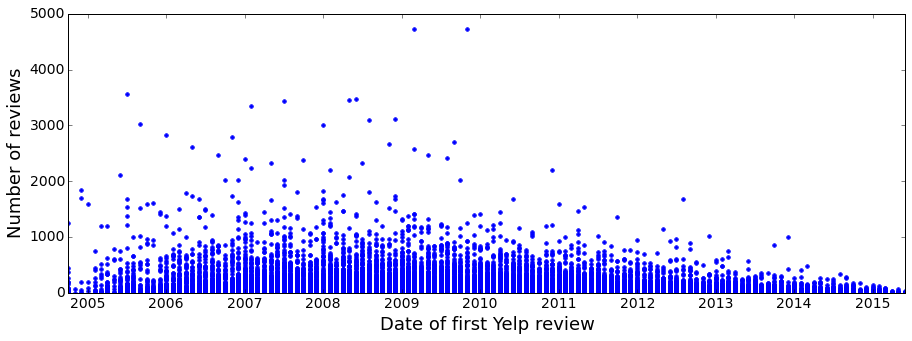

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df_usr.yelping_since, df_usr.review_count, '.')
plt.xlabel('Date of first Yelp review')
plt.ylabel('Number of reviews')

Note the histogram of average star ratings is not center at 3. We may consider normalizing each user's rating by their average rating.

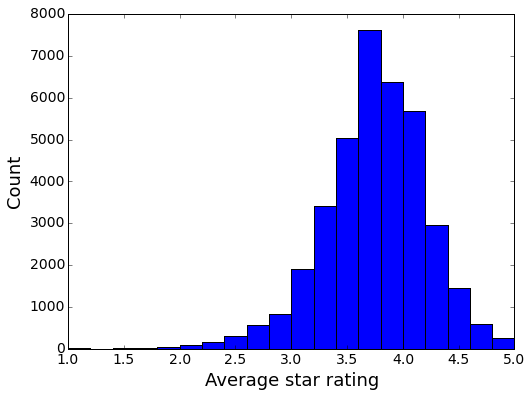

In [9]:
plt.hist(df_usr[df_usr['review_count'] > 10].average_stars, bins=20)
plt.xlabel('Average star rating')
plt.ylabel('Count')

One could perform a network analysis since we have the id's of each user's friends. Based on the number of votes of the friends we could figure out who are the most influential users and assign greater weight to their votes. We could also ignore this and weight individual reviews based on the number of votes they receive. However, we do not know if the votes came in the inspection window so we will refrain.

In [10]:
df_usr.sort_values('votes_useful', ascending=False)[['name', 'votes_useful', 'years_elite']][:10]

,name,votes_useful,years_elite
60122,Lolia,38334,3
24750,Brian,35106,0
16190,Anthony,33264,7
3492,Jessica,33159,11
20932,Colleen,29827,9
45583,Peter,26763,8
24414,Katie,26036,7
12444,Stephy,24591,4
16840,Katy,23215,7
11130,Bruce,21056,6


In [11]:
df_usr.sort_values('compliments_total', ascending=False)[['name', 'compliments_total', 'years_elite']][:10]

,name,compliments_total,years_elite
24750,Brian,191573,0
60122,Lolia,78344,3
16190,Anthony,41256,7
6947,DJ,31844,3
24414,Katie,29377,7
3492,Jessica,22926,11
20932,Colleen,22014,9
27347,Jando,21620,9
33703,Jennifer,20507,5
1127,Santi,20436,7


# Let's join the user data with the user reviews

In [12]:
from helper_methods import read_json
df_rev = read_json('data/yelp_academic_dataset_review.json')
df_rev.rename(columns={'date':'review_date'}, inplace=True)
df_rev.head(3)

,business_id,review_date,review_id,stars,text,type,user_id,votes
0,Jp9svt7sRT4zwdbzQ8KQmw,2005-08-26,OeT5kgUOe3vcN7H6ImVmZQ,3,This is a pretty typical cafe. The sandwiches...,review,P_Mk0ygOilLJo4_WEvabAA,"{u'funny': 0, u'useful': 0, u'cool': 0}"
1,Jp9svt7sRT4zwdbzQ8KQmw,2005-11-23,qq3zF2dDUh3EjMDuKBqhEA,3,I agree with other reviewers - this is a prett...,review,TNJRTBrl0yjtpAACr1Bthg,"{u'funny': 0, u'useful': 0, u'cool': 0}"
2,Jp9svt7sRT4zwdbzQ8KQmw,2005-11-23,i3eQTINJXe3WUmyIpvhE9w,3,"Decent enough food, but very overpriced. Just ...",review,H_mngeK3DmjlOu595zZMsA,"{u'funny': 0, u'useful': 0, u'cool': 0}"


In [13]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235213 entries, 0 to 235212
Data columns (total 8 columns):
business_id    235213 non-null object
review_date    235213 non-null datetime64[ns]
review_id      235213 non-null object
stars          235213 non-null int64
text           235213 non-null object
type           235213 non-null object
user_id        235213 non-null object
votes          235213 non-null object
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 16.2+ MB


Note that the number of unique id's in user data is equal to that in the reviews:

In [14]:
df_usr.user_id.unique().size == df_rev.user_id.unique().size

True

In [15]:
df_usr_rev = pd.merge(df_usr, df_rev, on='user_id', how='right')
df_usr_rev.head(3)

,average_stars,compliments,elite,fans,friends,name,review_count,user_id,yelping_since,years_elite,...,votes_useful,votes_cool,compliments_total,business_id,review_date,review_id,stars,text,type,votes
0,4.25,"{u'profile': 2, u'cute': 10, u'funny': 4, u'pl...","[2005, 2006, 2007]",17,"[rpOyqD_893cqmDAtJLbdog, 4U9kSBLuBDU391x6bxU-Y...",Brandon,193,E24Bu-vMhVpueQpU8mpRPw,2004-10-01,3,...,233,120,52,7L4nyg4fGloeqMXCq0996g,2005-06-24,lRdSCzNLfpthrjEIBF84Tg,5,I liked this place a lot. They have pretty go...,review,"{u'funny': 0, u'useful': 2, u'cool': 1}"
1,4.25,"{u'profile': 2, u'cute': 10, u'funny': 4, u'pl...","[2005, 2006, 2007]",17,"[rpOyqD_893cqmDAtJLbdog, 4U9kSBLuBDU391x6bxU-Y...",Brandon,193,E24Bu-vMhVpueQpU8mpRPw,2004-10-01,3,...,233,120,52,UMSwEeTTJF512vzQ3d1Zag,2005-07-01,ZFm99WdSSOQvUGfFIhFIwA,4,"Pricey (hey, it's seafood!), but pretty tasty,...",review,"{u'funny': 0, u'useful': 2, u'cool': 1}"
2,4.25,"{u'profile': 2, u'cute': 10, u'funny': 4, u'pl...","[2005, 2006, 2007]",17,"[rpOyqD_893cqmDAtJLbdog, 4U9kSBLuBDU391x6bxU-Y...",Brandon,193,E24Bu-vMhVpueQpU8mpRPw,2004-10-01,3,...,233,120,52,rMEfTzepRZucM_j7sFveKw,2005-07-01,mQkl4FaDFtgGmyXwzYlzLg,3,they have a half-price mexican night that's pr...,review,"{u'funny': 0, u'useful': 0, u'cool': 0}"


In [16]:
df_usr_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235213 entries, 0 to 235212
Data columns (total 22 columns):
average_stars        235213 non-null float64
compliments          235213 non-null object
elite                235213 non-null object
fans                 235213 non-null int64
friends              235213 non-null object
name                 235213 non-null object
review_count         235213 non-null int64
user_id              235213 non-null object
yelping_since        235213 non-null datetime64[ns]
years_elite          235213 non-null int64
number_of_friends    235213 non-null int64
votes_funny          235213 non-null int64
votes_useful         235213 non-null int64
votes_cool           235213 non-null int64
compliments_total    235213 non-null int64
business_id          235213 non-null object
review_date          235213 non-null datetime64[ns]
review_id            235213 non-null object
stars                235213 non-null int64
text                 235213 non-null object
t

In [17]:
stars_by_rev = df_usr_rev.groupby('user_id').agg({'stars':[np.size, np.mean, np.median]})
stars_by_rev.head(3)

stars                 
                        size      mean median
user_id                                      
---VHrmY76KEMOs62qthbw     1  5.000000    5.0
--0HEXd4W6bJI8k7E0RxTA     4  4.250000    4.0
--0KsjlAThNWua2Pr4HStQ     3  3.333333    3.0

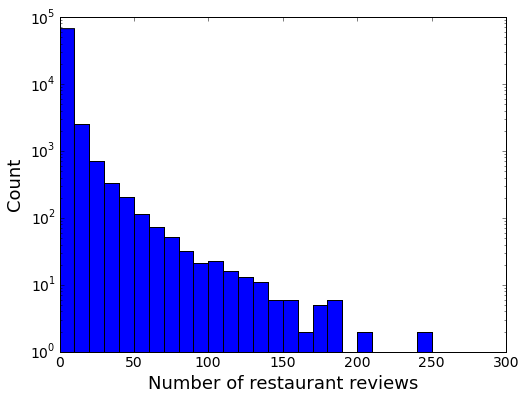

In [18]:
plt.hist(stars_by_rev[('stars', 'size')], bins=30, range=(0, 300), log=True)
plt.xlabel('Number of restaurant reviews')
plt.ylabel('Count')

In [19]:
star_comparison = pd.merge(stars_by_rev, df_usr, left_index=True, right_on='user_id', how='inner')
star_comparison.head(3)

,"(stars, size)","(stars, mean)","(stars, median)",average_stars,compliments,elite,fans,friends,name,review_count,user_id,yelping_since,years_elite,number_of_friends,votes_funny,votes_useful,votes_cool,compliments_total
7229,1,5.000000,5.0,4.08,"{u'profile': 2, u'funny': 2, u'cute': 3, u'pla...","[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]",6,"[pwHR68yMoT6MPgUPIW8yyA, DrKQzBFAvxhyjLgbPSW2Q...",Jessica,223,---VHrmY76KEMOs62qthbw,2006-01-01,8,7,52,361,114,89
55182,4,4.250000,4.0,4.24,{},[],2,[],JL,32,--0HEXd4W6bJI8k7E0RxTA,2012-05-01,0,0,2,14,4,0
58415,3,3.333333,3.0,3.93,"{u'funny': 2, u'hot': 1, u'writer': 1, u'plain...","[2014, 2015]",1,"[nELVJlkX8T0mUAArSPSJxw, D4v0v5fHzxYLWaXl8gTHq...",Steve,58,--0KsjlAThNWua2Pr4HStQ,2014-02-01,2,13,69,168,72,8


In [20]:
star_comparison.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71122 entries, 7229 to 58365
Data columns (total 18 columns):
(stars, size)        71122 non-null int64
(stars, mean)        71122 non-null float64
(stars, median)      71122 non-null float64
average_stars        71122 non-null float64
compliments          71122 non-null object
elite                71122 non-null object
fans                 71122 non-null int64
friends              71122 non-null object
name                 71122 non-null object
review_count         71122 non-null int64
user_id              71122 non-null object
yelping_since        71122 non-null datetime64[ns]
years_elite          71122 non-null int64
number_of_friends    71122 non-null int64
votes_funny          71122 non-null int64
votes_useful         71122 non-null int64
votes_cool           71122 non-null int64
compliments_total    71122 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(9), object(5)
memory usage: 10.3+ MB


Who has written the most restaurant reviews?

In [21]:
star_comparison.rename(columns={('stars', 'size'):'stars_size'}, inplace=True)
star_comparison[['name', 'stars_size']].sort_values('stars_size', ascending=False)[:10]

,name,stars_size
19897,Sara,288
20333,Michael,245
14255,Heather,240
25377,Brian,239
32125,Sarah,215
33921,Julie,202
35571,Kelly,201
45632,Josephine,199
22033,Amanda,188
7895,Lynda,188


The number of restaurant reviews is plotted against the number of total reviews written per user. We see that all users have written more total reviews than restaurant reviews. This makes sense.

(0, 2000)

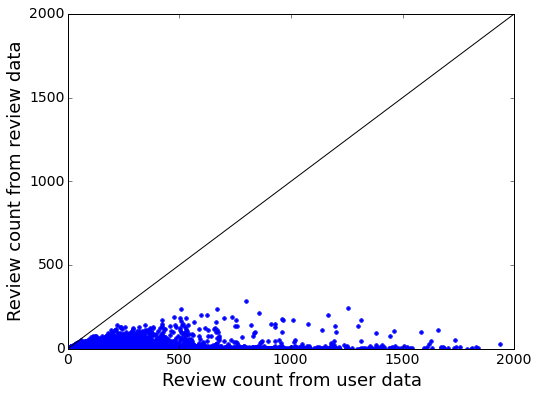

In [22]:
plt.plot(star_comparison.review_count, star_comparison.stars_size, '.')
plt.plot([0, 2000], [0, 2000], 'k-', lw=1)
plt.xlabel('Review count from user data')
plt.ylabel('Review count from review data')
plt.xlim(0, 2000)
plt.ylim(0, 2000)

Below we plot the average star rating computed using the review data against the average star rating of all the user's reviews. The data do not fall exactly on the 45 degree line because users rate different types of businesses differently.

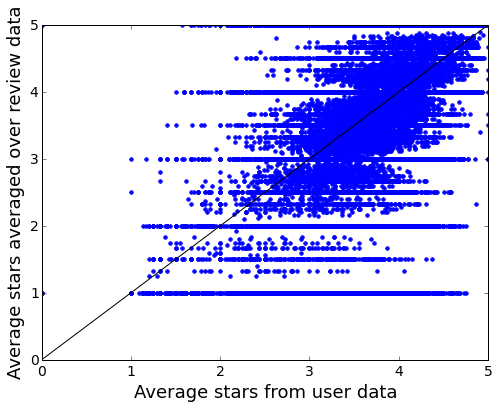

In [23]:
plt.plot(star_comparison.average_stars, star_comparison[('stars', 'mean')], '.')
plt.plot([0, 5], [0, 5], 'k-', lw=1)
plt.xlabel('Average stars from user data')
plt.ylabel('Average stars averaged over review data')

Let's see if there is a trend between number of friends each reviewer has and the number of compliments they received:

(0, 600)

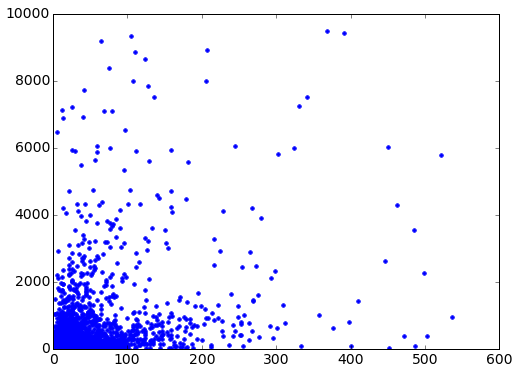

In [24]:
plt.plot(df_usr.number_of_friends, df_usr.compliments_total, '.')
plt.ylim(0, 10000)
plt.xlim(0, 600)

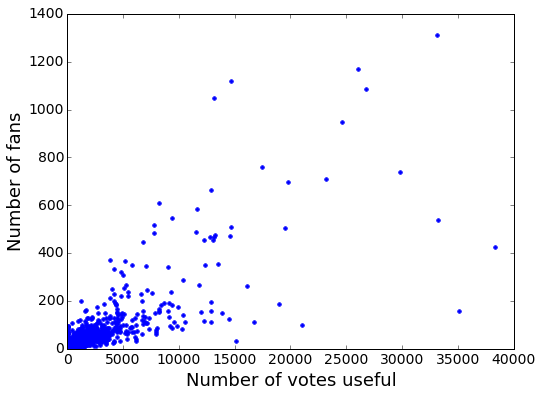

In [25]:
plt.plot(df_usr.votes_useful, df_usr.fans, '.')
plt.xlabel('Number of votes useful')
plt.ylabel('Number of fans')

In [26]:
from scipy.stats import pearsonr
r, p_value = pearsonr(df_usr.votes_useful, df_usr.fans)
print r, p_value

0.833374047748 0.0


### Conclusions

We have user data for each user review. However, it is not clear how to weight reviews based on who wrote them. We do not know if the votes that each review has received was cast during the inspection window or outside of it.